In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, time
import requests
import requests
import json
import pytz
import pandas as pd

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)  # Sin límite de columnas visibles
pd.set_option('display.width', 0)  # Configurar ancho dinámico para la pantalla
pd.set_option('display.max_rows', 100)

import os, sys
sys.path.append(r"C:\Users\jnavarro\Solaria Energía y Medio Ambiente\00-GEN - Documentos\Base de Datos\python")
from utils.connector import execute_query, insertar_dataframe_en_mysql # type: ignore

In [22]:
def get_df_indicadores_raw(start_date, end_date, indicator_ids):
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    query_indicadores = ", ".join([f"'{x}'" for x in indicator_ids])

    query = f"""SELECT Datetime_utc, indicator_id, geo_id, magnitud_id, value FROM t_api_esios_indicadores_data 
                WHERE Datetime BETWEEN '{start_date_str}' AND '{end_date_str}'
                AND indicator_id IN ({query_indicadores})"""
    df = execute_query(query, 'esios')

    return df

# Datos a pasado

### Funciones de extraccion y limpieza

In [23]:
def limpieza_df(df):
    global indicator_id_dict
    df_clean = df.copy()

    df_clean['Datetime_utc'] = pd.to_datetime(df_clean['Datetime_utc'])
    df_clean['Datetime_hour'] = df_clean['Datetime_utc'].dt.strftime('%Y-%m-%d %H:00:00')

    df_precios_potencia = df_clean.loc[df_clean['magnitud_id']!=13]
    df_energia = df_clean.loc[df_clean['magnitud_id']==13]

    # Agrupar por horas
    df_energia_hour = df_energia.groupby(['Datetime_hour', 'indicator_id'], as_index=False)['value'].sum()
    df_precios_potencia_hour = df_precios_potencia.groupby(['Datetime_hour', 'indicator_id'], as_index=False)['value'].mean()

    df_clean_hour = pd.concat([df_energia_hour, df_precios_potencia_hour], axis=0)

    # Hacer pivot - 1 columna por indicador
    df_clean_hour_pivot = df_clean_hour.pivot(index='Datetime_hour', columns='indicator_id', values='value').reset_index()
    

    # Renombrar columnas
    df_clean_hour_pivot.rename(columns=indicator_id_dict, inplace=True)

    cols_round = [col for col in df_clean_hour_pivot.columns if col not in ['Datetime_hour', 'MD', 'IDA1', 'IDA2']]
    df_clean_hour_pivot[cols_round] = df_clean_hour_pivot[cols_round].round(1)
    return df_clean_hour_pivot

In [74]:
start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 8, 1)
indicator_id_dict = {
    10257: 'Gen.P48 Total',
    10010: 'Gen.P48 Eolica',
    84: 'Gen.P48 Fotovoltaica',
    10027: 'Demanda P48',
    10026: 'Interconexiones P48',
    612: 'IDA1',
    613: 'IDA2',
    600: 'MD'
}

indicator_ids = list(indicator_id_dict.keys())
df = get_df_indicadores_raw(start_date, end_date, indicator_ids)

df_final = limpieza_df(df)

In [75]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13872 entries, 0 to 13871
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Datetime_hour         13872 non-null  object 
 1   Gen.P48 Fotovoltaica  13108 non-null  float64
 2   MD                    13872 non-null  float64
 3   IDA1                  13464 non-null  float64
 4   IDA2                  13656 non-null  float64
 5   Gen.P48 Eolica        13836 non-null  float64
 6   Interconexiones P48   13872 non-null  float64
 7   Demanda P48           13855 non-null  float64
 8   Gen.P48 Total         13836 non-null  float64
dtypes: float64(8), object(1)
memory usage: 975.5+ KB


### Tratamiento de nulos

Generacion Fotovoltaica

In [76]:
df_final.loc[df_final['Gen.P48 Fotovoltaica'].isnull()]

indicator_id,Datetime_hour,Gen.P48 Fotovoltaica,MD,IDA1,IDA2,Gen.P48 Eolica,Interconexiones P48,Demanda P48,Gen.P48 Total
3623,2024-05-30 22:00:00,NaN,10.00,9.00,5.90,13250.3,-3360.2,25249.2,28569.9
3624,2024-05-30 23:00:00,NaN,5.50,4.50,5.01,12854.8,-3454.0,23949.2,27422.2
3625,2024-05-31 00:00:00,NaN,4.77,4.62,5.00,12757.7,-3650.0,23237.7,26954.2
3626,2024-05-31 01:00:00,NaN,3.25,0.67,3.25,12370.9,-2954.1,22688.3,25776.4
3627,2024-05-31 02:00:00,NaN,3.25,0.02,3.25,11689.2,-2470.5,22475.9,24808.4
...,...,...,...,...,...,...,...,...,...
13248,2025-07-05 23:00:00,NaN,106.01,100.54,97.27,7158.8,-2114.2,25925.5,28468.7
13249,2025-07-06 00:00:00,NaN,103.60,92.38,91.68,6716.9,-1580.0,24484.9,26681.4
13251,2025-07-06 02:00:00,NaN,100.10,90.98,85.76,5519.6,-1225.6,22753.9,24745.9
13252,2025-07-06 03:00:00,NaN,100.82,92.57,92.77,5082.6,-1597.9,22565.6,24567.5


In [77]:
# Los valores nulos corresponden a horas no solares, así que reemplazamos por 0
df_final['Gen.P48 Fotovoltaica'] = df_final['Gen.P48 Fotovoltaica'].fillna(0.0)

Generacion Total

In [78]:
df_final.loc[df_final['Gen.P48 Total'].isnull()]

indicator_id,Datetime_hour,Gen.P48 Fotovoltaica,MD,IDA1,IDA2,Gen.P48 Eolica,Interconexiones P48,Demanda P48,Gen.P48 Total
11603,2025-04-28 10:00:00,0.0,-1.01,-0.01,0.00,NaN,-1943.4,-2118.4,NaN
11604,2025-04-28 11:00:00,0.0,-2.50,-2.50,-1.00,NaN,236.0,236.0,NaN
11605,2025-04-28 12:00:00,0.0,-3.00,-2.27,-0.01,NaN,802.2,277.2,NaN
11606,2025-04-28 13:00:00,0.0,-1.54,0.00,0.00,NaN,1418.7,1418.7,NaN
11607,2025-04-28 14:00:00,0.0,-0.30,-5.77,-0.01,NaN,1433.5,1433.5,NaN
11608,2025-04-28 15:00:00,0.0,-0.01,-1.01,0.00,NaN,1174.2,1174.2,NaN
11609,2025-04-28 16:00:00,0.0,0.01,0.65,1.72,NaN,1837.8,1837.8,NaN
11610,2025-04-28 17:00:00,0.0,5.20,15.20,15.46,NaN,1515.8,1515.8,NaN
11611,2025-04-28 18:00:00,0.0,40.70,47.37,58.23,NaN,950.5,950.5,NaN
11612,2025-04-28 19:00:00,0.0,80.80,80.79,85.80,NaN,853.2,853.2,NaN


In [79]:
# Corresponde al día del apagón. Lo cual también explica los nulos en Gen. Eolica y Demanda
# Es una situación excepcional pero sustituimos también por 0 para replicar la realidad
df_final[['Gen.P48 Total', 'Gen.P48 Eolica', 'Demanda P48']] = df_final[['Gen.P48 Total', 'Gen.P48 Eolica', 'Demanda P48']].fillna(0.0)

Precios IDA1 y IDA2

In [80]:
df_final.loc[(df_final['IDA1'].isnull()) | (df_final['IDA2'].isnull())]

indicator_id,Datetime_hour,Gen.P48 Fotovoltaica,MD,IDA1,IDA2,Gen.P48 Eolica,Interconexiones P48,Demanda P48,Gen.P48 Total
3959,2024-06-13 22:00:00,0.0,78.86,NaN,88.86,6255.6,-338.4,23897.4,24814.8
3960,2024-06-13 23:00:00,0.0,76.44,NaN,80.75,5998.5,-331.7,22826.6,23537.4
3961,2024-06-14 00:00:00,0.0,75.72,NaN,75.72,5748.5,-363.9,22117.9,22734.8
3962,2024-06-14 01:00:00,0.0,75.30,NaN,75.30,5527.8,-380.1,21719.6,22272.2
3963,2024-06-14 02:00:00,0.9,75.72,NaN,75.72,5223.0,-351.4,21591.8,22096.2
...,...,...,...,...,...,...,...,...,...
13722,2025-07-25 17:00:00,12742.8,30.85,NaN,79.99,9239.3,-5845.2,28682.7,37187.0
13723,2025-07-25 18:00:00,5045.6,85.00,NaN,93.50,10693.0,-5101.3,29173.8,34889.6
13724,2025-07-25 19:00:00,475.8,104.72,NaN,99.72,12192.2,-3776.1,29227.4,34284.4
13725,2025-07-25 20:00:00,0.2,101.94,NaN,98.55,13264.8,-3470.3,28297.4,33423.7


In [81]:
# Sustituimos los valores nulos del IDA1 por los del IDA2 y viceversa
# Cuando ambos son nulos, tomamos el valor del MD
df_final['IDA1'] = np.where(
    df_final['IDA1'].isnull(),
    np.where(df_final['IDA2'].isnull(), df_final['MD'], df_final['IDA2']),
    df_final['IDA1']
)
df_final['IDA2'] = np.where(
    df_final['IDA2'].isnull(),
    np.where(df_final['IDA1'].isnull(), df_final['MD'], df_final['IDA1']),
    df_final['IDA2']
)

### Guardar los datos en un archivo CSV

In [82]:
df_final.to_csv('data_training/esios_data_modelo_dl.csv', index=False)

# Datos a futuro

### Esios

In [62]:
start_date = datetime(2023, 12, 24)
end_date = datetime(2025, 8, 1)
indicator_id_dict = {
    1775: 'Demanda',
    1777: 'Gen.Eolica',
    1779: 'Gen.Fotovoltaica',
    600: 'MD'
}

indicator_ids = list(indicator_id_dict.keys())
df = get_df_indicadores_raw(start_date, end_date, indicator_ids)
df

,Datetime_utc,indicator_id,geo_id,magnitud_id,value
0,2023-12-31 23:00:00,600,3,23,63.33
1,2024-01-01 00:00:00,600,3,23,50.09
2,2024-01-01 01:00:00,600,3,23,47.50
3,2024-01-01 02:00:00,600,3,23,43.50
4,2024-01-01 03:00:00,600,3,23,42.50
...,...,...,...,...,...
55483,2025-07-31 18:00:00,1779,8741,13,3899.30
55484,2025-07-31 19:00:00,1779,8741,13,336.30
55485,2025-07-31 20:00:00,1779,8741,13,0.00
55486,2025-07-31 21:00:00,1779,8741,13,0.00


In [63]:
def limpieza_df(df):
    global indicator_id_dict
    df_clean = df.copy()

    df_clean['Datetime_utc'] = pd.to_datetime(df_clean['Datetime_utc'])
    df_clean['Datetime_hour'] = df_clean['Datetime_utc'].dt.strftime('%Y-%m-%d %H:00:00')

    df_precios_potencia = df_clean.loc[df_clean['magnitud_id']!=13]
    df_energia = df_clean.loc[df_clean['magnitud_id']==13]

    # Agrupar por horas
    df_energia_hour = df_energia.groupby(['Datetime_hour', 'indicator_id'], as_index=False)['value'].sum()
    df_precios_potencia_hour = df_precios_potencia.groupby(['Datetime_hour', 'indicator_id'], as_index=False)['value'].mean()

    df_clean_hour = pd.concat([df_energia_hour, df_precios_potencia_hour], axis=0)

    # Hacer pivot - 1 columna por indicador
    df_clean_hour_pivot = df_clean_hour.pivot(index='Datetime_hour', columns='indicator_id', values='value').reset_index()
    

    # Renombrar columnas
    df_clean_hour_pivot.rename(columns=indicator_id_dict, inplace=True)

    cols_round = [col for col in df_clean_hour_pivot.columns if col not in ['Datetime_hour', 'MD', 'IDA1', 'IDA2']]
    df_clean_hour_pivot[cols_round] = df_clean_hour_pivot[cols_round].round(1)
    return df_clean_hour_pivot

In [64]:
df_clean_previsiones = limpieza_df(df)
df_clean_previsiones['MD_lag_24'] = df_clean_previsiones['MD'].shift(24)
df_clean_previsiones['MD_lag_48'] = df_clean_previsiones['MD'].shift(48)
df_clean_previsiones['MD_lag_1week'] = df_clean_previsiones['MD'].shift(24*7)
df_clean_previsiones

indicator_id,Datetime_hour,MD,Demanda,Gen.Eolica,Gen.Fotovoltaica,MD_lag_24,MD_lag_48,MD_lag_1week
0,2023-12-31 23:00:00,63.33,21638.0,4702.8,0.0,NaN,NaN,NaN
1,2024-01-01 00:00:00,50.09,20746.8,4626.0,0.0,NaN,NaN,NaN
2,2024-01-01 01:00:00,47.50,19292.3,4489.0,0.0,NaN,NaN,NaN
3,2024-01-01 02:00:00,43.50,18262.3,4359.5,0.0,NaN,NaN,NaN
4,2024-01-01 03:00:00,42.50,17620.5,4371.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
13867,2025-07-31 18:00:00,107.99,32459.3,9680.5,3899.3,77.99,57.58,50.00
13868,2025-07-31 19:00:00,114.45,32319.0,11117.5,336.3,101.49,98.00,90.92
13869,2025-07-31 20:00:00,110.27,31198.8,10593.8,0.0,104.36,103.27,90.68
13870,2025-07-31 21:00:00,98.32,28856.5,10664.5,0.0,92.18,84.13,71.05


### OMIP

In [65]:
query = """SELECT Date, Dia_extraccion, FTB, FTS FROM omip_data 
        WHERE `Interval Type`='D' AND Date > '2024-01-01'"""
df_omip_1 = execute_query(query, 'omip')

query = """SELECT Date, Dia_extraccion, FTB, FTS FROM t_omip_forecast_hist 
        WHERE `Interval Type`='D' AND Date > '2024-01-01'"""
df_omip_2 = execute_query(query, 'omip')

df_omip = pd.concat([df_omip_1, df_omip_2], axis=0)
df_omip = df_omip.drop_duplicates(keep='first').sort_values(by='Date')
df_omip[['Date', 'Dia_extraccion']] = df_omip[['Date', 'Dia_extraccion']].apply(pd.to_datetime)
df_omip

,Date,Dia_extraccion,FTB,FTS
0,2024-01-02,2023-12-29,52.460,47.420
1,2024-01-03,2023-12-29,52.380,47.110
2,2024-01-03,2024-01-02,55.080,60.000
5,2024-01-04,2024-01-03,91.360,92.170
3,2024-01-04,2023-12-29,52.920,47.840
...,...,...,...,...
1549,2025-08-30,2025-08-25,51.870,19.980
1553,2025-08-31,2025-08-25,48.130,17.460
1555,2025-08-31,2025-08-27,46.120,10.200
1552,2025-08-31,2025-08-22,49.410,18.740


In [66]:
# Eliminamos los datos en los que solo hay un día de diferencia entre la fecha y la extracción
df_omip = df_omip[df_omip['Date'] != df_omip['Dia_extraccion'] + pd.Timedelta(days=1)].copy()
df_omip['Date'] = df_omip['Date'].dt.strftime('%Y-%m-%d')

# Agrupamos por Date y nos quedamos con el Dia_extraccion más reciente
df_omip = df_omip.sort_values(by=['Dia_extraccion'])
df_omip = df_omip.drop_duplicates(subset=['Date'], keep='last').drop(columns=['Dia_extraccion'])
df_omip

,Date,FTB,FTS
0,2024-01-02,52.460,47.420
1,2024-01-03,52.380,47.110
4,2024-01-04,45.890,41.270
8,2024-01-05,56.270,53.010
13,2024-01-06,53.390,45.720
...,...,...,...
1538,2025-08-27,67.930,36.110
1542,2025-08-28,60.000,31.380
1547,2025-08-29,46.500,11.260
1551,2025-08-30,49.880,11.880


In [67]:
# Comprobacion dias faltantes
df_omip['Date'] = pd.to_datetime(df_omip['Date'])
todos_los_dias_2024 = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')

# Verificar qué días faltan
dias_presentes = set(df_omip['Date'])
dias_faltantes = [dia for dia in todos_los_dias_2024 if dia not in dias_presentes]
print(dias_faltantes)

df_omip['Date'] = df_omip['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

[Timestamp('2024-01-01 00:00:00')]


### MIBGAS

In [68]:
df_mibgas1 = pd.read_excel('data_training/MIBGAS_Data_2025.xlsx', sheet_name=2)
df_mibgas2 = pd.read_excel('data_training/MIBGAS_Data_2024.xlsx', sheet_name=2)
df_mibgas = pd.concat([df_mibgas1, df_mibgas2], ignore_index=True)

df_mibgas['Trading day'] = pd.to_datetime(df_mibgas['Trading day'])
df_mibgas['Date'] = df_mibgas['Trading day']

df_mibgas = df_mibgas.loc[df_mibgas['Product'].isin(['GDAES_D+2', 'GDAES_D+3'])]

df_mibgas.loc[df_mibgas['Product']=='GDAES_D+2', 'Date'] += pd.Timedelta(days=2)
df_mibgas.loc[df_mibgas['Product']=='GDAES_D+3', 'Date'] += pd.Timedelta(days=3)
df_mibgas.columns

df_mibgas_precio = df_mibgas[['Date', "Reference Price\n[EUR/MWh]"]].rename(columns={"Reference Price\n[EUR/MWh]":'Precio_Gas'})
df_mibgas_precio.dropna(axis=0, inplace=True)

df_mibgas_precio = df_mibgas_precio.groupby('Date', as_index=False).agg({'Precio_Gas': 'mean'})
df_mibgas_precio['Precio_Gas'] = df_mibgas_precio['Precio_Gas'].round(2)
df_mibgas_precio['Date'] = df_mibgas_precio['Date'].dt.strftime('%Y-%m-%d')
df_mibgas_precio

,Date,Precio_Gas
0,2024-01-03,30.17
1,2024-01-04,30.54
2,2024-01-05,30.96
3,2024-01-06,32.98
4,2024-01-07,34.04
...,...,...
599,2025-08-24,32.44
600,2025-08-25,33.12
601,2025-08-26,33.12
602,2025-08-27,33.22


### CO2

In [97]:
df_co2_1 = pd.read_csv('data_training/historico-precios-CO2-_2024_.csv', sep=';')
df_co2_2 = pd.read_csv('data_training/historico-precios-CO2-_2025_.csv', sep=';')
df_co2 = pd.concat([df_co2_1, df_co2_2])

df_co2['Fecha'] = pd.to_datetime(df_co2['Fecha'], format='%d-%m-%Y')
df_co2['Fecha'] = df_co2['Fecha'].dt.strftime('%Y-%m-%d')
df_co2.rename(columns={'Fecha': 'Date'}, inplace=True)

df_co2_precio = df_co2[['Date', 'EUA']].rename(columns={'EUA': 'Precio_CO2'})

# Añadimos fechas restantes

df_co2_precio['Date'] = pd.to_datetime(df_co2_precio['Date'])

# Agrupar por fecha para eliminar duplicados (tomando el último valor disponible)
df_co2_precio = df_co2_precio.groupby('Date').last()

# Crear rango completo de fechas
full_range = pd.date_range(start='2024-02-01', end='2025-08-27')

# Reindexar y rellenar valores faltantes hacia atrás (last available)
df_co2_precio_full = df_co2_precio.reindex(full_range, method='ffill')

# Renombrar índice a columna Date
df_co2_precio_full = df_co2_precio_full.rename_axis('Date').reset_index()

df_co2_precio_full['Date'] = df_co2_precio_full['Date'].dt.strftime('%Y-%m-%d')
df_co2_precio_full['Precio_CO2_lag48'] = df_co2_precio_full['Precio_CO2'].shift(2)
df_co2_precio_full = df_co2_precio_full.drop(columns=['Precio_CO2']).dropna()
df_co2_precio_full

,Date,Precio_CO2_lag48
2,2024-02-03,60.18
3,2024-02-04,61.27
4,2024-02-05,61.27
5,2024-02-06,61.27
6,2024-02-07,60.55
...,...,...
569,2025-08-23,72.09
570,2025-08-24,71.97
571,2025-08-25,71.97
572,2025-08-26,71.97


### Dataframe final

In [98]:
# Unir ambos dataframes por Date

# Calculamos la fecha en España (Datetime_hour está en UTC)
utc_zone = pytz.utc
spain_zone = pytz.timezone('Europe/Madrid')
df_clean_previsiones['Datetime_hour'] = pd.to_datetime(df_clean_previsiones['Datetime_hour'])
df_clean_previsiones['Datetime_hour_Spain'] = df_clean_previsiones['Datetime_hour'].dt.tz_localize(utc_zone).dt.tz_convert(spain_zone)
df_clean_previsiones['Hour'] = df_clean_previsiones['Datetime_hour_Spain'].dt.hour
df_clean_previsiones['Month'] = df_clean_previsiones['Datetime_hour_Spain'].dt.month
df_clean_previsiones['Day_of_week'] = df_clean_previsiones['Datetime_hour_Spain'].dt.dayofweek


df_clean_previsiones['Date'] = df_clean_previsiones['Datetime_hour_Spain'].dt.strftime('%Y-%m-%d')
df_clean_previsiones.drop(columns=['Datetime_hour_Spain'], inplace=True)

# Hacemos merge con el df de omip
df_previsiones_omip = pd.merge(df_clean_previsiones, df_omip, on='Date', how='inner')
df_previsiones_omip_mibgas = pd.merge(df_previsiones_omip, df_mibgas_precio, on='Date', how='inner')
df_final_futuro = pd.merge(df_previsiones_omip_mibgas, df_co2_precio_full, on='Date', how='inner')
df_final_futuro.drop(columns=['Date'], inplace=True)
print(df_final_futuro.info())
df_final_futuro

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13032 entries, 0 to 13031
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Datetime_hour     13032 non-null  datetime64[ns]
 1   MD                13032 non-null  float64       
 2   Demanda           13032 non-null  float64       
 3   Gen.Eolica        13032 non-null  float64       
 4   Gen.Fotovoltaica  13032 non-null  float64       
 5   MD_lag_24         13032 non-null  float64       
 6   MD_lag_48         13032 non-null  float64       
 7   MD_lag_1week      13032 non-null  float64       
 8   Hour              13032 non-null  int32         
 9   Month             13032 non-null  int32         
 10  Day_of_week       13032 non-null  int32         
 11  FTB               13032 non-null  object        
 12  FTS               13032 non-null  object        
 13  Precio_Gas        13032 non-null  float64       
 14  Precio_CO2_lag48  1303

,Datetime_hour,MD,Demanda,Gen.Eolica,Gen.Fotovoltaica,MD_lag_24,MD_lag_48,MD_lag_1week,Hour,Month,Day_of_week,FTB,FTS,Precio_Gas,Precio_CO2_lag48
0,2024-02-02 23:00:00,56.44,25367.3,6204.3,0.0,62.95,69.00,64.97,0,2,5,61.450,52.580,29.24,60.18
1,2024-02-03 00:00:00,52.71,23677.3,5596.0,0.0,60.05,60.44,61.06,1,2,5,61.450,52.580,29.24,60.18
2,2024-02-03 01:00:00,51.18,22408.5,5060.5,0.0,58.00,55.10,59.05,2,2,5,61.450,52.580,29.24,60.18
3,2024-02-03 02:00:00,50.83,21695.8,4637.3,0.0,54.69,54.60,55.90,3,2,5,61.450,52.580,29.24,60.18
4,2024-02-03 03:00:00,51.16,21351.0,4365.0,0.0,52.41,53.47,55.90,4,2,5,61.450,52.580,29.24,60.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13027,2025-07-31 18:00:00,107.99,32459.3,9680.5,3899.3,77.99,57.58,50.00,20,7,3,35.730,8.970,32.90,72.39
13028,2025-07-31 19:00:00,114.45,32319.0,11117.5,336.3,101.49,98.00,90.92,21,7,3,35.730,8.970,32.90,72.39
13029,2025-07-31 20:00:00,110.27,31198.8,10593.8,0.0,104.36,103.27,90.68,22,7,3,35.730,8.970,32.90,72.39
13030,2025-07-31 21:00:00,98.32,28856.5,10664.5,0.0,92.18,84.13,71.05,23,7,3,35.730,8.970,32.90,72.39


In [99]:
df_final_futuro.to_csv('data_training/predictores_modelo_futuro.csv', index=False)

# Analisis de correlacion

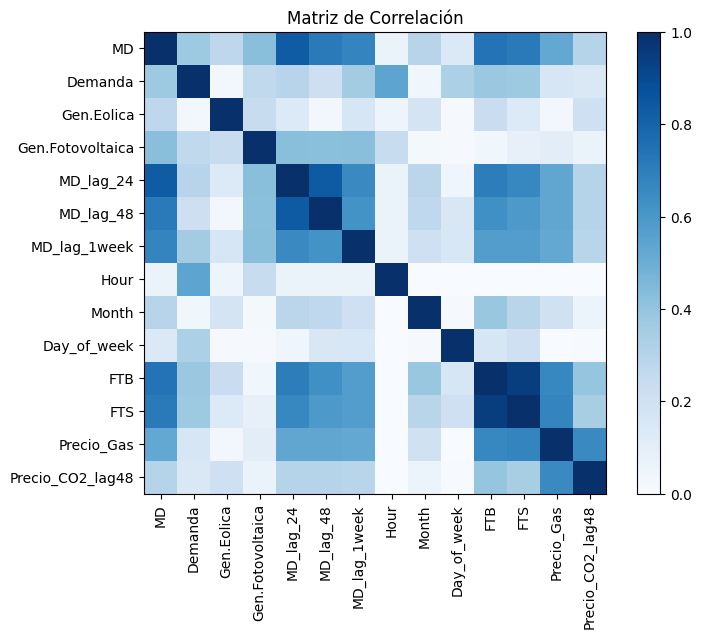

In [100]:
df_sin_fecha = df_final_futuro.drop(columns=['Datetime_hour'])

correlation_matrix = df_sin_fecha.corr()
correlation_matrix = correlation_matrix.abs()

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='Blues', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Matriz de Correlación')
plt.show()